In [27]:
from ftplib import FTP
from io import BytesIO
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt



In [104]:

def download_spectrum_ftp(ftp_url):
    ftp_host = "ftp.eso.org"
    ftp_path = ftp_url.replace("ftp://ftp.eso.org/", "")
    
    with FTP(ftp_host) as ftp:
        ftp.login()
        with BytesIO() as bio:
            ftp.retrbinary(f"RETR {ftp_path}", bio.write)
            bio.seek(0)
            return bio.getvalue() 

# solo spectros en main sequence (que terminen en v)
spectra_urls = {
    "O": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko5v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uko9v.fits"

    ],
    "B": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukb1v.fits"
    ],
    "A": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/uka2v.fits"
    ],
    "F": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukf2v.fits"
    ],
    "G": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukg2v.fits"
    ],
    "K": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukk2v.fits"
    ],
    "M": [
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm0v.fits",
        "ftp://ftp.eso.org/web/sci/observing/tools/standards/IR_spectral_library/ukm1v.fits"
    ]
}

spectra = {}
for key, urls in spectra_urls.items():
    spectra[key] = [download_spectrum_ftp(url) for url in urls]


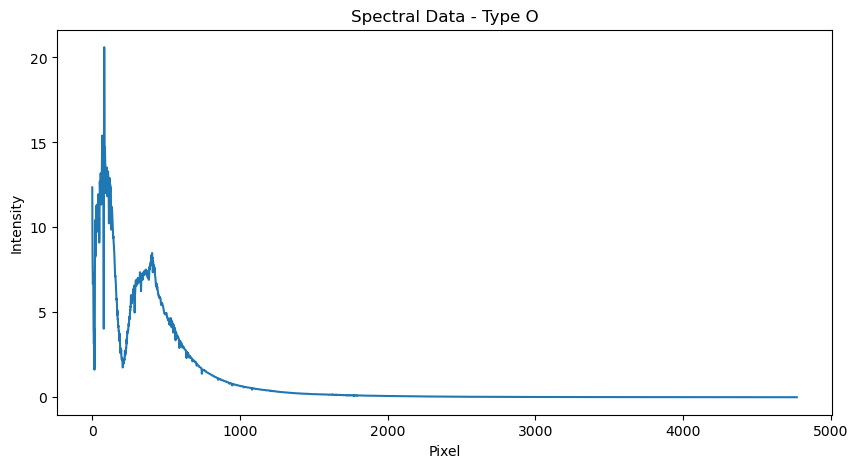

In [105]:

# Esto esta acá porque sino se me cerraban los fits

def open_fits_from_data(data):
    with fits.open(BytesIO(data)) as hdul:
        header = hdul[0].header
        data = hdul[0].data
        return header, data

# Ejemplo con espectro O
fits_data_O = spectra['O'][0]

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)


# print("Header keys:", header_O.keys())
# print("First few data points:", data_O[:10])

# Visualizar el espectro
plt.figure(figsize=(10,5))
plt.plot(data_O)
plt.xlabel('Pixel')
plt.ylabel('Intensity')
plt.title('Spectral Data - Type O')
plt.show()


In [30]:
#info del header
header_O

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 4771 / Axis length                                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
EXTEND  =                    F / File may contain extensions                    
DATE    = '2000-02-16T18:17:18' / Date FITS file was generated                  
IRAF-TLM= '15:17:17 (16/02/2000)' / Time of last modification                   
APNUM1  = '1 1     '                                                            
WCSDIM  =                    1                                                  
CTYPE1  = 'LINEAR  '                                                            
CRVAL1  =                1150.                                                  
CRPIX1  =                   

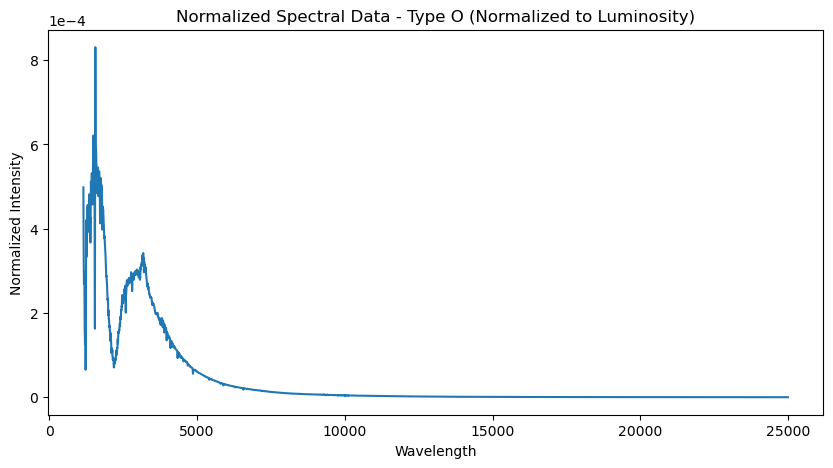

Luminosity of Type O spectrum: 24804.11807811528


In [98]:


# Integrar la luminosidad con respecto a long de onda, asi obtenemos la luminosidad total del espectro
def calculate_total_luminosity(wavelength, spectrum):
    luminosity = np.trapz(spectrum, x=wavelength)
    return luminosity 

# Función para normalizar un espectro estelar en relación a la luminosidad total

def normalize_spectrum_to_luminosity(header, data):
    # Infio del header
    crpix1 = header['CRPIX1']  # Punto de referencia del píxel
    crval1 = header['CRVAL1']  # Valor del píxel en crpix1
    cdelt1 = header['CDELT1']  # Incremento por píxel

    # Calcular el rango de longitud de onda
    wavelength = crval1 + (np.arange(len(data)) - crpix1 + 1) * cdelt1

    # integramos
    total_luminosity = calculate_total_luminosity(wavelength, data)

    # Normalizar el espectro dividiendo por la luminosidad total
    normalized_spectrum = data  / total_luminosity

    return wavelength, normalized_spectrum, total_luminosity

# Ejemplo
fits_data_O = spectra['O'][0]

# Obtener la cabecera y los datos del archivo FITS
header_O, data_O = open_fits_from_data(fits_data_O)

# Normalizar el espectro en relación a la luminosidad
wavelength_O, normalized_spectrum_O, total_luminosity_O = normalize_spectrum_to_luminosity(header_O, data_O)

# Visualizar el espectro normalizado (opcional)
plt.figure(figsize=(10,5))
plt.plot(wavelength_O, normalized_spectrum_O)
plt.xlabel('Wavelength')
plt.ylabel('Normalized Intensity')
plt.title('Normalized Spectral Data - Type O (Normalized to Luminosity)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.show()

# Imprimir la luminosidad total del espectro (opcional)
print(f"Luminosity of Type O spectrum: {total_luminosity_O}")

In [106]:

# Automatizado para todo
all_spectra_data = {}

for key, spectra_list in spectra.items():
    all_spectra_data[key] = []
    for fits_data in spectra_list:
        
        header, data = open_fits_from_data(fits_data)
        
        wavelength, normalized_spectrum, total_luminosity = normalize_spectrum_to_luminosity(header, data)
        
        all_spectra_data[key].append({
            'header': header,
            'data': data,
            'wavelength': wavelength,
            'normalized_spectrum': normalized_spectrum,
            'total_luminosity': total_luminosity
        })

for key, spectra_list in all_spectra_data.items():
    print(f"Type {key} spectra:")
    for idx, spectrum_data in enumerate(spectra_list):
        print(f"Spectrum {idx + 1}: Total Luminosity = {spectrum_data['total_luminosity']} erg/s")


Type O spectra:
Spectrum 1: Total Luminosity = 24804.11807811528 erg/s
Spectrum 2: Total Luminosity = 64560.390511720325 erg/s
Type B spectra:
Spectrum 1: Total Luminosity = 66340.11379241594 erg/s
Spectrum 2: Total Luminosity = 46580.775226939004 erg/s
Type A spectra:
Spectrum 1: Total Luminosity = 8276.418107565842 erg/s
Spectrum 2: Total Luminosity = 7534.038258211222 erg/s
Type F spectra:
Spectrum 1: Total Luminosity = 6690.0616004328 erg/s
Spectrum 2: Total Luminosity = 6622.871028425079 erg/s
Type G spectra:
Spectrum 1: Total Luminosity = 6975.68477616087 erg/s
Spectrum 2: Total Luminosity = 7297.414025598791 erg/s
Type K spectra:
Spectrum 1: Total Luminosity = 7726.988819530776 erg/s
Spectrum 2: Total Luminosity = 8376.425316915847 erg/s
Type M spectra:
Spectrum 1: Total Luminosity = 16961.40091382714 erg/s
Spectrum 2: Total Luminosity = 19674.720405838012 erg/s


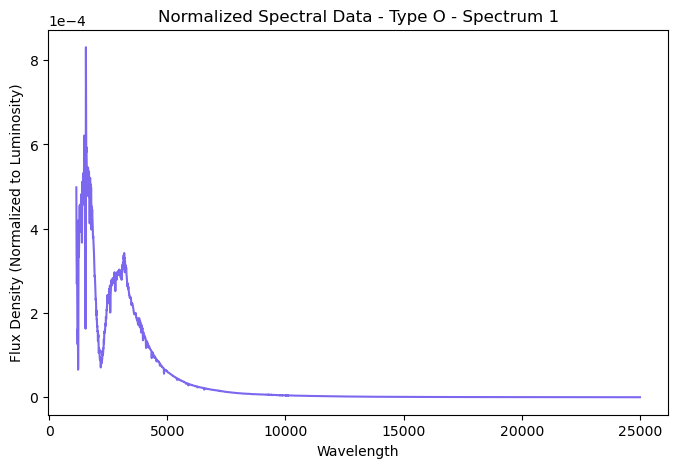

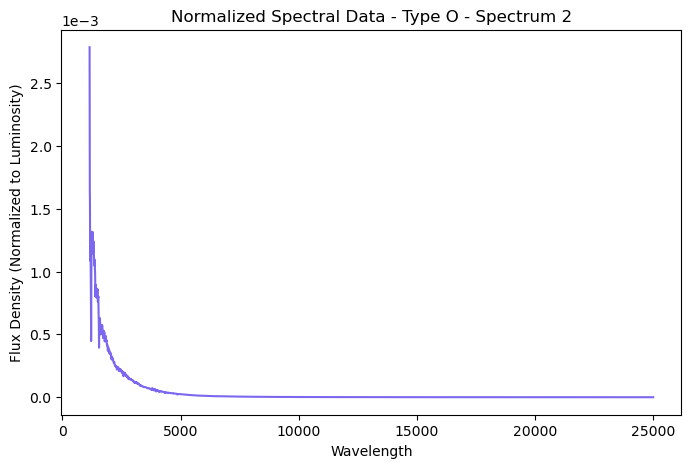

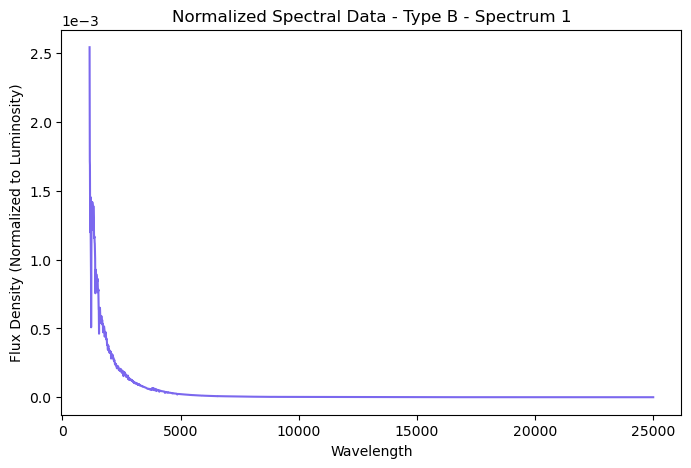

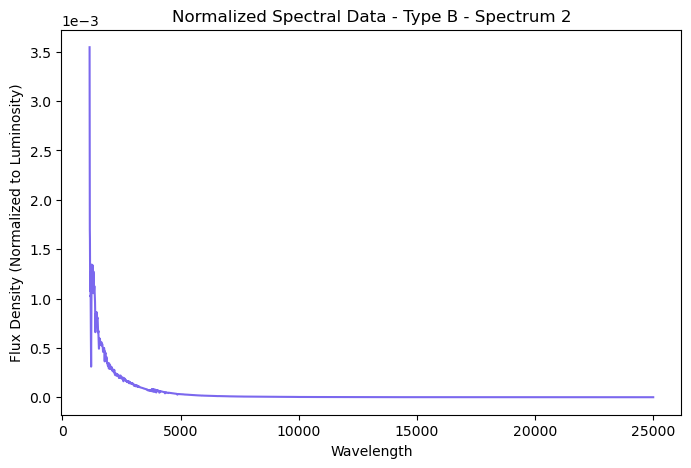

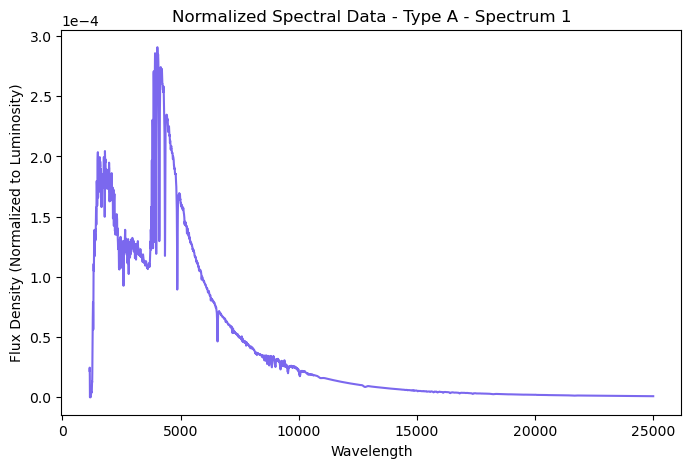

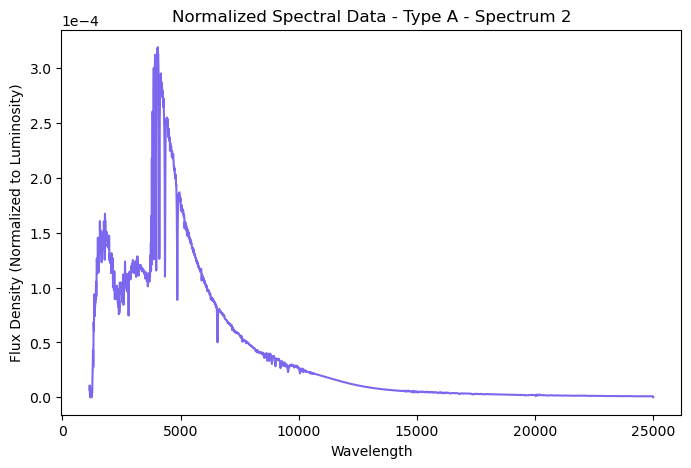

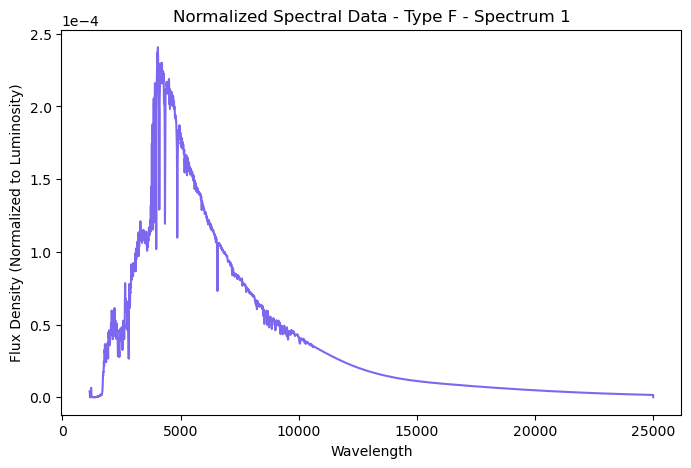

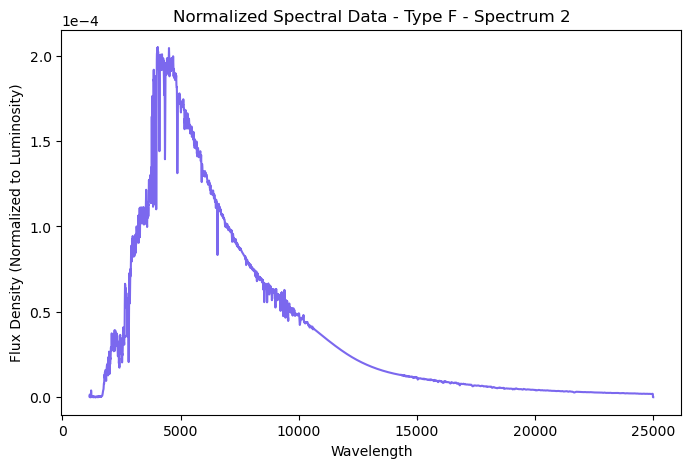

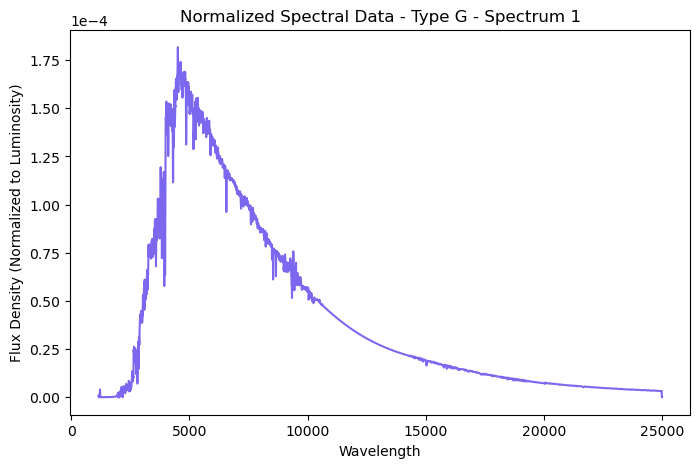

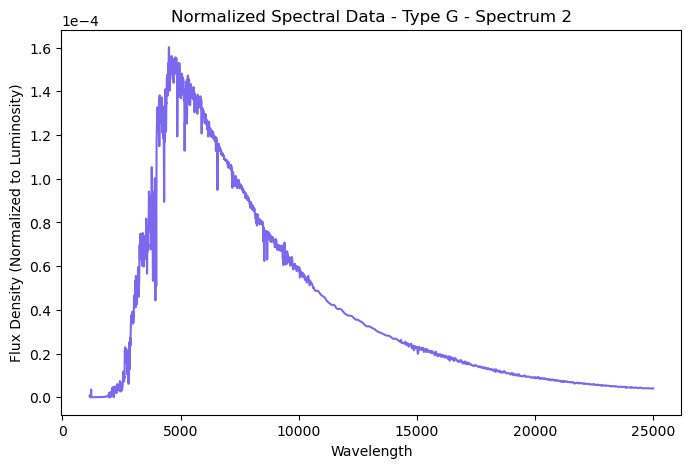

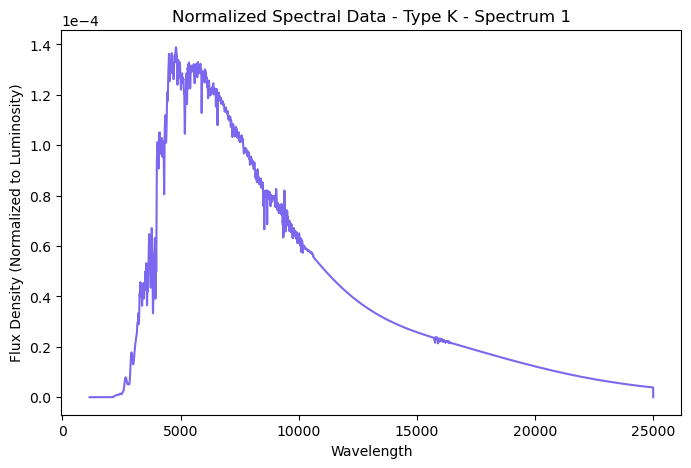

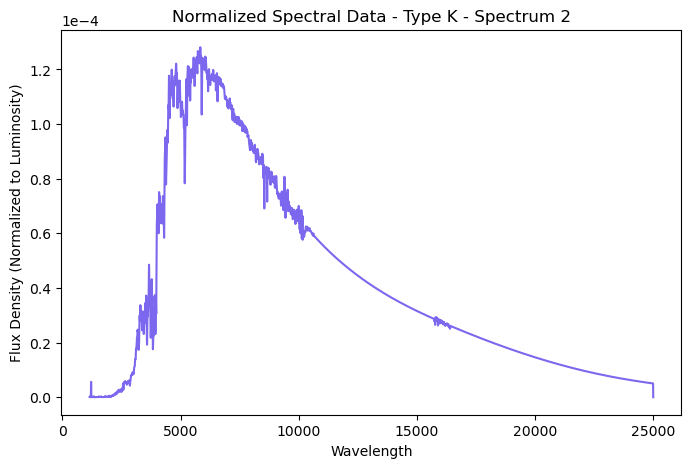

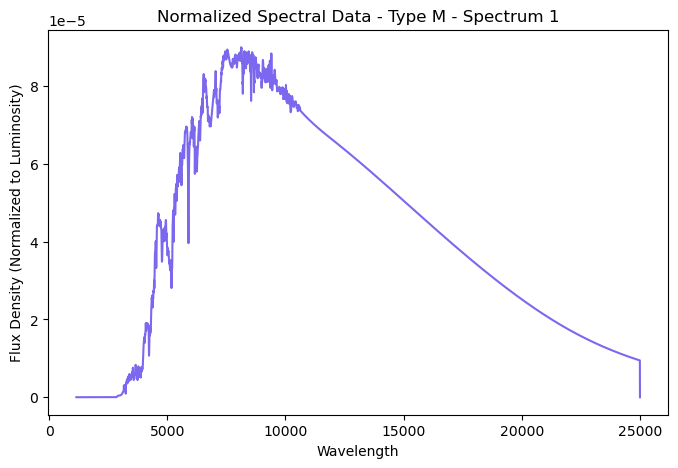

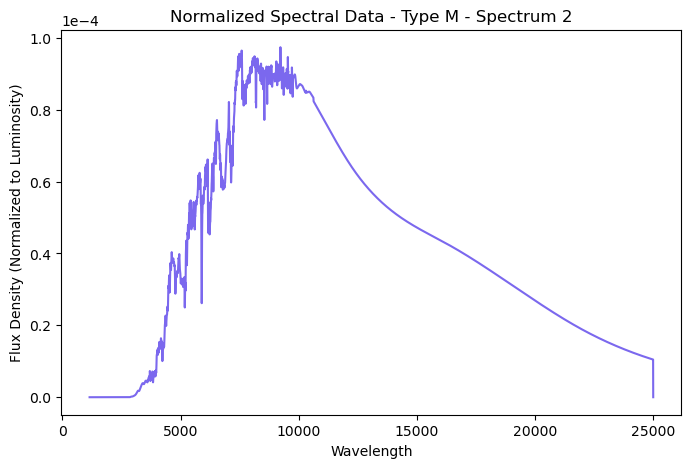

In [107]:
#Todos los graficos

for key, spectra_list in all_spectra_data.items():
    for idx, spectrum_data in enumerate(spectra_list):
        plt.figure(figsize=(8, 5))
        plt.plot(spectrum_data['wavelength'], spectrum_data['normalized_spectrum'], color='mediumslateblue')
        plt.xlabel('Wavelength')
        plt.ylabel('Flux Density (Normalized to Luminosity)')
        plt.title(f'Normalized Spectral Data - Type {key} - Spectrum {idx + 1}')
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        plt.show()
